### *This file allows to initialize a STG spiking neuron as well as neuromodulating them in a robust way with a controller*

# **Useful packages and functions**

In [1]:
using DifferentialEquations, Plots, Plots.PlotMeasures, LaTeXStrings, Random, Dierckx
include("STG_kinetics.jl") # Loading of STG kinetics of gating variables
include("STG_models.jl") # Loading of STG model
include("STG_utils.jl") # Loading of some utils functions
include("STG_gs_derivatives.jl") # Loading of X_inf derivatives
include("STG_DIC.jl") # Loading of the DIC and compensation algorithm
include("STG_neuromodulation.jl"); # Loading of the neuromodulation cells functions

# **Global variables**

In [2]:
# Definition of simulation time (in ms)
const Tfinal = 300000
const tspan  = (0.0, Tfinal)

# Definition of reversal potential values (in mV) and membrane capacitance
const VNa   = 50. # Sodium reversal potential
const VK    = -80. # Potassium reversal potential
const VCa   = 80. # Calcium reversal potential
const VH    = -20. # Reversal potential for the H-current (permeable to both sodium and potassium ions)
const Vleak = -50. # Reversal potential of leak channels
const C     = 1. # Membrane capacitance

# Definition of voltage range for the DICs
const Vmin = -60 
const Vmax = 0
const V    = range(Vmin, stop=Vmax, step=0.01)

# Definition of the number of cells in the random set
const ncells = 200

# Modifying backend GR attributes
gr(guidefontsize=18, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
myGray = RGBA(150/255, 150/255, 150/255, 1)
myLightBlue = RGBA(127/255, 154/255, 209/255, 1)
default(fmt = :png);

# **Neuromodulation gCaS and gA overall**

## **Computation of gCaS and gA**

In [3]:
# Fixing random seed
Random.seed!(544)

# Initial firing pattern
guth = 4.
Vth = -50.
(g_all_init, ICs_th_init) = degeneracy_fixDICs_neuromod(ncells, 5., guth, Vth)
# create a spiking set with max variability in gCaS and gA

# Neuromodulating the initial set to the same value of gs_th (convention in the codes)
(g_all_spiking, ICs_th_bursting) = neuromodCaSA(ncells, g_all_init, ICs_th_init, 5., guth);
# (g_all_bursting, ICs_th_bursting) = neuromodCaSA(ncells, g_all_init, ICs_th_init, -8., guth);

In [4]:
# Definition of homeostatic parameters
tau_g = 100 # Conductance time constant
Ca_tgt(t) = 125. # Calcium target

# Input current definition
Iapp = 0.

tt = 0. : 0.2 : 50000.

tt2 = 0. : 0.2 : Tfinal
end_i = findall(tt2.==70000)[1]

tt_s = 0. : 0.1 : 80.;

## **Simulation to prove that homeostasis crashes, neuron 1**

In [5]:
Random.seed!(22)
# Extracting the maximal ion channel conductances
rng_i1 = mod(rand(Int, 1)[1], ncells) + 1
(gNa1, gCaT1, gCaS1, gA1, gKCa1, gKd1, gH1, gleak1) = g_all_spiking[rng_i1, :];

In [6]:
# Definition of homeostatic parameters
tau_Na1 = 600 # Integral action time constants
tau_CaT1 = tau_Na1 * gNa1 / gCaT1
tau_KCa1 = tau_Na1 * gNa1 / gKCa1
tau_Kd1 = tau_Na1 * gNa1 / gKd1
tau_H1 = tau_Na1 * gNa1 / gH1
tau_leak1 = tau_Na1 * gNa1 / gleak1
tau_CaS1 = tau_Na1 * gNa1 / gCaS1
tau_A1 = tau_Na1 * gNa1 / gA1;

In [7]:
(gCaS_crash_1, gA_crash_1) = DICs_gmax_neuromodCaSA(gNa1, gCaT1, 
    gKd1, gKCa1, gH1, gleak1, -8., 4., ICs_th_init[rng_i1, 1]);

In [8]:
## Simulation of the model in current-clamp mode
# Parameter vector for simulations
gNa_crash_init1 = gNa1
gCaT_crash_init1 = gCaT1
gCaS_crash_init1 = gCaS_crash_1
gA_crash_init1 = gA_crash_1
gKCa_crash_init1 = gKCa1
gKd_crash_init1 = gKd1
gH_crash_init1 = gH1
gleak_crash_init1 = gleak1

p1_1 = (Iapp, tau_Na1, tau_CaT1, tau_CaS1, tau_A1, tau_KCa1, tau_Kd1, tau_H1, tau_leak1, tau_g, Ca_tgt, C)

# Initial conditions
V0  = -70.
Ca0 = 0.5
x01_1  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), hCaS_inf(V0), 
          mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0, 
          gNa_crash_init1, gCaT_crash_init1, gCaS_crash_init1, gA_crash_init1, 
          gKCa_crash_init1, gKd_crash_init1, gH_crash_init1, gleak_crash_init1,
          gNa_crash_init1, gCaT_crash_init1, gCaS_crash_init1, gA_crash_init1, 
          gKCa_crash_init1, gKd_crash_init1, gH_crash_init1, gleak_crash_init1]

# Simulation
prob1_1 = ODEProblem(STG_homeo_leak_ODE, x01_1, tspan, p1_1) # Describing the problem
sol1_1 = solve(prob1_1) # Solving the problem

# Retrieving variables
x1_1          = sol1_1(tt2)
VV_plot1_1    = x1_1[1, :]
Ca_plot1_1    = x1_1[13, :]
gNa_plot1_1   = x1_1[14, :]
gCaT_plot1_1  = x1_1[15, :]
gCaS_plot1_1  = x1_1[16, :]
gA_plot1_1    = x1_1[17, :]
gKCa_plot1_1  = x1_1[18, :]
gKd_plot1_1   = x1_1[19, :]
gH_plot1_1    = x1_1[20, :]
gleak_plot1_1 = x1_1[21, :];

In [9]:
length_before_nmod = length(tt[Int64(40000/0.2 + 1):500:end])
gNa_nmodonly1 = gNa1 * ones(length_before_nmod)
gCaT_nmodonly1 = gCaT1 * ones(length_before_nmod)
gCaS_nmodonly1 = gCaS1 * ones(length_before_nmod)
gA_nmodonly1 = gA1 * ones(length_before_nmod)
gKCa_nmodonly1 = gKCa1 * ones(length_before_nmod)
gKd_nmodonly1 = gKd1 * ones(length_before_nmod)
gH_nmodonly1 = gH1 * ones(length_before_nmod)
gleak_nmodonly1 = gleak1 * ones(length_before_nmod)

gCaS_crash1 = [gCaS_nmodonly1; gCaS_plot1_1[2:500:end_i]]
gA_crash1 = [gA_nmodonly1; gA_plot1_1[2:500:end_i]]

gNa_crash1 = [gNa_nmodonly1; gNa_plot1_1[2:500:end_i]]
gCaT_crash1 = [gCaT_nmodonly1; gCaT_plot1_1[2:500:end_i]]
gKCa_crash1 = [gKCa_nmodonly1; gKCa_plot1_1[2:500:end_i]]
gKd_crash1 = [gKd_nmodonly1; gKd_plot1_1[2:500:end_i]]
gH_crash1 = [gH_nmodonly1; gH_plot1_1[2:500:end_i]];

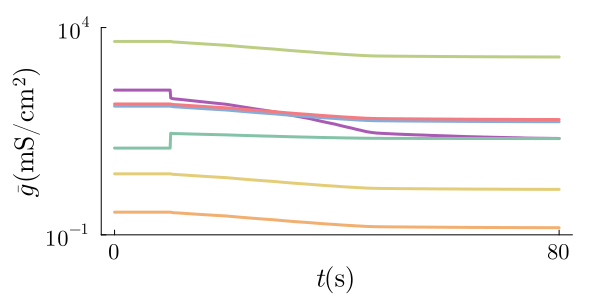

In [10]:
pp1 = plot(ylims=(1e-1, 1e4), yticks=([1e-1, 1e4], [L"10^{-1}", L"10^{4}"]), guidefontsize=18,
           xticks=([0, 80], [L"0", L"80"]), tickfontsize=15, size=(600, 300))
xlabel!(L"t\mathrm{(s)}")
ylabel!(L"\bar{g}\,\mathrm{(mS/cm^2)}")
plot!(tt_s, gA_crash1, color=myPurple, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt_s, gCaS_crash1, color=myGreen, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt_s, gNa_crash1, color=myApple, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gCaT_crash1, color=myYellow, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gKCa_crash1, color=myBlue, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gKd_crash1, color=myPink, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gH_crash1, color=myOrange, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
display(pp1)
# savefig(pp1, "./figures/crash_g_all_1.pdf")

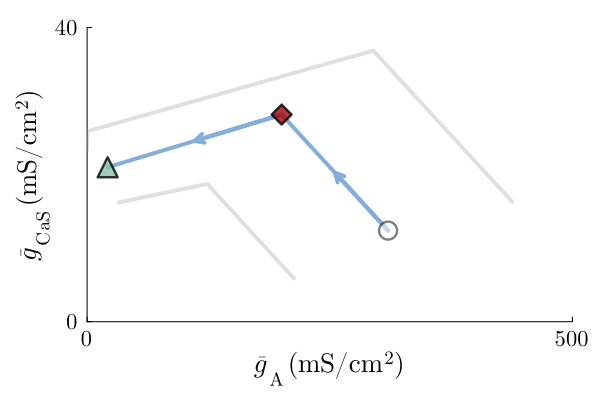

In [37]:
pp1b = plot(legend=false, tickfontsize=15, markerstrokewidth=0., size=(600, 400), 
            xticks=([0, 500], [L"0", L"500"]), yticks=([0, 40], [L"0", L"40"]))

# Plotting
plot!(max.(0., gA_crash1), gCaS_crash1, label="", grid=false, color=myBlue,
      linewidth=4, yguidefontsize=18, xguidefontsize=18)

plot!(max.(0., gA_crash2), gCaS_crash2, label="", grid=false, color=myGray, alpha=0.3,
      linewidth=4, yguidefontsize=18, xguidefontsize=18)

plot!(max.(0., gA_crash3), gCaS_crash3, label="", grid=false, color=myGray, alpha=0.3,
      linewidth=4, yguidefontsize=18, xguidefontsize=18)

gA_arrow1 = [gA_crash1[1], (gA_crash1[length_before_nmod+1]+gA_crash1[1])/2]
gCaS_arrow1 = [gCaS_crash1[1], (gCaS_crash1[length_before_nmod+1]+gCaS_crash1[1])/2]

plot!(gA_arrow1, gCaS_arrow1, label="", grid=false, color=myBlue,
      linewidth=4, yguidefontsize=18, xguidefontsize=18, arrow=true)

gA_arrow2 = [gA_crash1[length_before_nmod+1], (gA_crash1[length_before_nmod+1]+gA_crash1[end])/2]
gCaS_arrow2 = [gCaS_crash1[length_before_nmod+1], (gCaS_crash1[length_before_nmod+1]+gCaS_crash1[end])/2]

plot!(gA_arrow2, gCaS_arrow2, label="", grid=false, color=myBlue,
      linewidth=4, yguidefontsize=18, xguidefontsize=18, arrow=true)

scatter!([gA_crash1[1]], [gCaS_crash1[1]], color=:white, alpha=0.5, markersize=10, markerstrokewidth=3)

scatter!([gA_crash1[length_before_nmod+1]], [gCaS_crash1[length_before_nmod+1]], color=myRed, alpha=0.8,
         markershape=:diamond, markersize=10, markerstrokewidth=3)

scatter!([gA_crash1[end]], [gCaS_crash1[end]], color=myGreen, alpha=0.8,
         markershape=:utriangle, markersize=10, markerstrokewidth=3)

xlims!((0, 500))
ylims!((0, 40))

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")

display(pp1b)
# savefig(pp1b, "./figures/gCaSgA_crash_gspace1.pdf")

## **Simulation to prove that homeostasis crashes, neuron 2**

In [13]:
Random.seed!(2025)
# Extracting the maximal ion channel conductances
rng_i2 = mod(rand(Int, 1)[1], ncells) + 1
(gNa2, gCaT2, gCaS2, gA2, gKCa2, gKd2, gH2, gleak2) = g_all_spiking[rng_i2, :];

In [14]:
# Definition of homeostatic parameters
tau_Na2 = 600 # Integral action time constants
tau_CaT2 = tau_Na2 * gNa2 / gCaT2
tau_KCa2 = tau_Na2 * gNa2 / gKCa2
tau_Kd2 = tau_Na2 * gNa2 / gKd2
tau_H2 = tau_Na2 * gNa2 / gH2
tau_leak2 = tau_Na2 * gNa2 / gleak2
tau_CaS2 = tau_Na2 * gNa2 / gCaS2
tau_A2 = tau_Na2 * gNa2 / gA2;

In [15]:
(gCaS_crash_2, gA_crash_2) = DICs_gmax_neuromodCaSA(gNa2, gCaT2, 
    gKd2, gKCa2, gH2, gleak2, -8., 4., ICs_th_init[rng_i2, 1]);

In [16]:
## Simulation of the model in current-clamp mode
# Parameter vector for simulations
gNa_crash_init2 = gNa2
gCaT_crash_init2 = gCaT2
gCaS_crash_init2 = gCaS_crash_2
gA_crash_init2 = gA_crash_2
gKCa_crash_init2 = gKCa2
gKd_crash_init2 = gKd2
gH_crash_init2 = gH2
gleak_crash_init2 = gleak2

p2_1 = (Iapp, tau_Na2, tau_CaT2, tau_CaS2, tau_A2, tau_KCa2, tau_Kd2, tau_H2, tau_leak2, tau_g, Ca_tgt, C)

# Initial conditions
V0  = -70.
Ca0 = 0.5
x02_1  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), hCaS_inf(V0), 
          mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0, 
          gNa_crash_init2, gCaT_crash_init2, gCaS_crash_init2, gA_crash_init2, 
          gKCa_crash_init2, gKd_crash_init2, gH_crash_init2, gleak_crash_init2,
          gNa_crash_init2, gCaT_crash_init2, gCaS_crash_init2, gA_crash_init2, 
          gKCa_crash_init2, gKd_crash_init2, gH_crash_init2, gleak_crash_init2]

# Simulation
prob2_1 = ODEProblem(STG_homeo_leak_ODE, x02_1, tspan, p2_1) # Describing the problem
sol2_1 = solve(prob2_1) # Solving the problem

# Retrieving variables
x2_1          = sol2_1(tt2)
VV_plot2_1    = x2_1[1, :]
Ca_plot2_1    = x2_1[13, :]
gNa_plot2_1   = x2_1[14, :]
gCaT_plot2_1  = x2_1[15, :]
gCaS_plot2_1  = x2_1[16, :]
gA_plot2_1    = x2_1[17, :]
gKCa_plot2_1  = x2_1[18, :]
gKd_plot2_1   = x2_1[19, :]
gH_plot2_1    = x2_1[20, :]
gleak_plot2_1 = x2_1[21, :];

In [17]:
length_before_nmod = length(tt[Int64(40000/0.2 + 1):500:end])
gNa_nmodonly2 = gNa2 * ones(length_before_nmod)
gCaT_nmodonly2 = gCaT2 * ones(length_before_nmod)
gCaS_nmodonly2 = gCaS2 * ones(length_before_nmod)
gA_nmodonly2 = gA2 * ones(length_before_nmod)
gKCa_nmodonly2 = gKCa2 * ones(length_before_nmod)
gKd_nmodonly2 = gKd2 * ones(length_before_nmod)
gH_nmodonly2 = gH2 * ones(length_before_nmod)
gleak_nmodonly2 = gleak2 * ones(length_before_nmod)

gCaS_crash2 = [gCaS_nmodonly2; gCaS_plot2_1[2:500:end_i]]
gA_crash2 = [gA_nmodonly2; gA_plot2_1[2:500:end_i]]

gNa_crash2 = [gNa_nmodonly2; gNa_plot2_1[2:500:end_i]]
gCaT_crash2 = [gCaT_nmodonly2; gCaT_plot2_1[2:500:end_i]]
gKCa_crash2 = [gKCa_nmodonly2; gKCa_plot2_1[2:500:end_i]]
gKd_crash2 = [gKd_nmodonly2; gKd_plot2_1[2:500:end_i]]
gH_crash2 = [gH_nmodonly2; gH_plot2_1[2:500:end_i]];

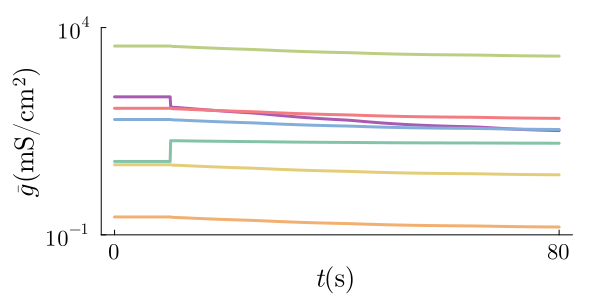

In [18]:
pp2 = plot(ylims=(1e-1, 1e4), yticks=([1e-1, 1e4], [L"10^{-1}", L"10^{4}"]), guidefontsize=18,
           xticks=([0, 80], [L"0", L"80"]), tickfontsize=15, size=(600, 300))
xlabel!(L"t\mathrm{(s)}")
ylabel!(L"\bar{g}\,\mathrm{(mS/cm^2)}")
plot!(tt_s, gA_crash2, color=myPurple, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt_s, gCaS_crash2, color=myGreen, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt_s, gNa_crash2, color=myApple, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gCaT_crash2, color=myYellow, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gKCa_crash2, color=myBlue, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gKd_crash2, color=myPink, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gH_crash2, color=myOrange, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
display(pp2)
# savefig(pp2, "./figures/crash_g_all_2.pdf")

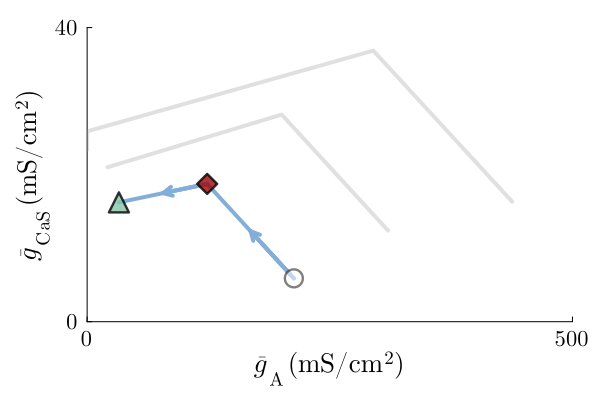

In [39]:
pp2b = plot(legend=false, tickfontsize=15, markerstrokewidth=0., size=(600, 400), 
            xticks=([0, 500], [L"0", L"500"]), yticks=([0, 40], [L"0", L"40"]))

# Plotting
plot!(max.(0., gA_crash2), gCaS_crash2, label="", grid=false, color=myBlue,
      linewidth=4, yguidefontsize=18, xguidefontsize=18)

plot!(max.(0., gA_crash1), gCaS_crash1, label="", grid=false, color=myGray, alpha=0.3,
      linewidth=4, yguidefontsize=18, xguidefontsize=18)

plot!(max.(0., gA_crash3), gCaS_crash3, label="", grid=false, color=myGray, alpha=0.3,
      linewidth=4, yguidefontsize=18, xguidefontsize=18)

gA_arrow1 = [gA_crash2[1], (gA_crash2[length_before_nmod+1]+gA_crash2[1])/2]
gCaS_arrow1 = [gCaS_crash2[1], (gCaS_crash2[length_before_nmod+1]+gCaS_crash2[1])/2]

plot!(gA_arrow1, gCaS_arrow1, label="", grid=false, color=myBlue,
      linewidth=4, yguidefontsize=18, xguidefontsize=18, arrow=true)

gA_arrow2 = [gA_crash2[length_before_nmod+1], (gA_crash2[length_before_nmod+1]+gA_crash2[end])/2]
gCaS_arrow2 = [gCaS_crash2[length_before_nmod+1], (gCaS_crash2[length_before_nmod+1]+gCaS_crash2[end])/2]

plot!(gA_arrow2, gCaS_arrow2, label="", grid=false, color=myBlue,
      linewidth=4, yguidefontsize=18, xguidefontsize=18, arrow=true)

scatter!([gA_crash2[1]], [gCaS_crash2[1]], color=:white, alpha=0.5, markersize=10, markerstrokewidth=3)

scatter!([gA_crash2[length_before_nmod+1]], [gCaS_crash2[length_before_nmod+1]], color=myRed, alpha=0.8,
         markershape=:diamond, markersize=10, markerstrokewidth=3)

scatter!([gA_crash2[end]], [gCaS_crash2[end]], color=myGreen, alpha=0.8,
         markershape=:utriangle, markersize=10, markerstrokewidth=3)

xlims!((0, 500))
ylims!((0, 40))

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")

display(pp2b)
# savefig(pp2b, "./figures/gCaSgA_crash_gspace2.pdf")

## **Simulation to prove that homeostasis crashes, neuron 3**

In [20]:
Random.seed!(2024)
# Extracting the maximal ion channel conductances
rng_i3 = mod(rand(Int, 1)[1], ncells) + 1
(gNa3, gCaT3, gCaS3, gA3, gKCa3, gKd3, gH3, gleak3) = g_all_spiking[rng_i3, :];

In [21]:
# Definition of homeostatic parameters
tau_Na3 = 600 # Integral action time constants
tau_CaT3 = tau_Na3 * gNa3 / gCaT3
tau_KCa3 = tau_Na3 * gNa3 / gKCa3
tau_Kd3 = tau_Na3 * gNa3 / gKd3
tau_H3 = tau_Na3 * gNa3 / gH3
tau_leak3 = tau_Na3 * gNa3 / gleak3
tau_CaS3 = tau_Na3 * gNa3 / gCaS3
tau_A3 = tau_Na3 * gNa3 / gA3;

In [22]:
(gCaS_crash_3, gA_crash_3) = DICs_gmax_neuromodCaSA(gNa3, gCaT3, 
    gKd3, gKCa3, gH3, gleak3, -8., 4., ICs_th_init[rng_i3, 1]);

In [23]:
## Simulation of the model in current-clamp mode
# Parameter vector for simulations
gNa_crash_init3 = gNa3
gCaT_crash_init3 = gCaT3
gCaS_crash_init3 = gCaS_crash_3
gA_crash_init3 = gA_crash_3
gKCa_crash_init3 = gKCa3
gKd_crash_init3 = gKd3
gH_crash_init3 = gH3
gleak_crash_init3 = gleak3

p3_1 = (Iapp, tau_Na3, tau_CaT3, tau_CaS3, tau_A3, tau_KCa3, tau_Kd3, tau_H3, tau_leak3, tau_g, Ca_tgt, C)

# Initial conditions
V0  = -70.
Ca0 = 0.5
x03_1  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), hCaS_inf(V0), 
          mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0, 
          gNa_crash_init3, gCaT_crash_init3, gCaS_crash_init3, gA_crash_init3, 
          gKCa_crash_init3, gKd_crash_init3, gH_crash_init3, gleak_crash_init3,
          gNa_crash_init3, gCaT_crash_init3, gCaS_crash_init3, gA_crash_init3, 
          gKCa_crash_init3, gKd_crash_init3, gH_crash_init3, gleak_crash_init3]

# Simulation
prob3_1 = ODEProblem(STG_homeo_leak_ODE, x03_1, tspan, p3_1) # Describing the problem
sol3_1 = solve(prob3_1) # Solving the problem

# Retrieving variables
x3_1          = sol3_1(tt2)
VV_plot3_1    = x3_1[1, :]
Ca_plot3_1    = x3_1[13, :]
gNa_plot3_1   = x3_1[14, :]
gCaT_plot3_1  = x3_1[15, :]
gCaS_plot3_1  = x3_1[16, :]
gA_plot3_1    = x3_1[17, :]
gKCa_plot3_1  = x3_1[18, :]
gKd_plot3_1   = x3_1[19, :]
gH_plot3_1    = x3_1[20, :]
gleak_plot3_1 = x3_1[21, :];

In [24]:
length_before_nmod = length(tt[Int64(40000/0.2 + 1):500:end])
gNa_nmodonly3 = gNa3 * ones(length_before_nmod)
gCaT_nmodonly3 = gCaT3 * ones(length_before_nmod)
gCaS_nmodonly3 = gCaS3 * ones(length_before_nmod)
gA_nmodonly3 = gA3 * ones(length_before_nmod)
gKCa_nmodonly3 = gKCa3 * ones(length_before_nmod)
gKd_nmodonly3 = gKd3 * ones(length_before_nmod)
gH_nmodonly3 = gH3 * ones(length_before_nmod)
gleak_nmodonly3 = gleak3 * ones(length_before_nmod)

gCaS_crash3 = [gCaS_nmodonly3; gCaS_plot3_1[2:500:end_i]]
gA_crash3 = [gA_nmodonly3; gA_plot3_1[2:500:end_i]]

gNa_crash3 = [gNa_nmodonly3; gNa_plot3_1[2:500:end_i]]
gCaT_crash3 = [gCaT_nmodonly3; gCaT_plot3_1[2:500:end_i]]
gKCa_crash3 = [gKCa_nmodonly3; gKCa_plot3_1[2:500:end_i]]
gKd_crash3 = [gKd_nmodonly3; gKd_plot3_1[2:500:end_i]]
gH_crash3 = [gH_nmodonly3; gH_plot3_1[2:500:end_i]];

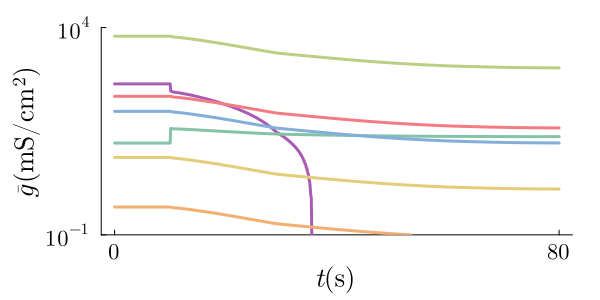

┌ Warning: Invalid negative or zero value -0.10591718237772614 found at series index 357 for log10 based yscale
└ @ Plots C:\Users\arthu\.julia\packages\Plots\gzYVM\src\utils.jl:100


In [25]:
pp3 = plot(ylims=(1e-1, 1e4), yticks=([1e-1, 1e4], [L"10^{-1}", L"10^{4}"]), guidefontsize=18,
           xticks=([0, 80], [L"0", L"80"]), tickfontsize=15, size=(600, 300))
xlabel!(L"t\mathrm{(s)}")
ylabel!(L"\bar{g}\,\mathrm{(mS/cm^2)}")
plot!(tt_s, gA_crash3, color=myPurple, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt_s, gCaS_crash3, color=myGreen, linewidth=3,
      legend=false, alpha=1, yaxis=:log)
plot!(tt_s, gNa_crash3, color=myApple, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gCaT_crash3, color=myYellow, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gKCa_crash3, color=myBlue, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gKd_crash3, color=myPink, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
plot!(tt_s, gH_crash3, color=myOrange, linewidth=3, legend=false, 
      alpha=1, yaxis=:log)
display(pp3)
# savefig(pp3, "./figures/crash_g_all_3.pdf")

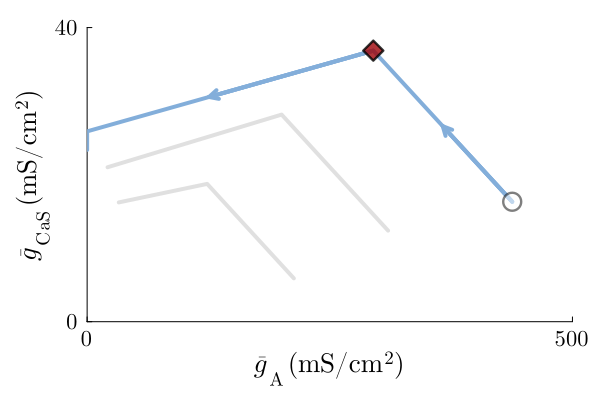

In [41]:
pp3b = plot(legend=false, tickfontsize=15, markerstrokewidth=0., size=(600, 400), 
            xticks=([0, 500], [L"0", L"500"]), yticks=([0, 40], [L"0", L"40"]))

# Plotting
plot!(max.(0., gA_crash3), gCaS_crash3, label="", grid=false, color=myBlue,
      linewidth=4, yguidefontsize=18, xguidefontsize=18)

plot!(max.(0., gA_crash2), gCaS_crash2, label="", grid=false, color=myGray, alpha=0.3,
      linewidth=4, yguidefontsize=18, xguidefontsize=18)

plot!(max.(0., gA_crash1), gCaS_crash1, label="", grid=false, color=myGray, alpha=0.3,
      linewidth=4, yguidefontsize=18, xguidefontsize=18)

gA_arrow1 = [gA_crash3[1], (gA_crash3[length_before_nmod+1]+gA_crash3[1])/2]
gCaS_arrow1 = [gCaS_crash3[1], (gCaS_crash3[length_before_nmod+1]+gCaS_crash3[1])/2]

plot!(gA_arrow1, gCaS_arrow1, label="", grid=false, color=myBlue,
      linewidth=4, yguidefontsize=18, xguidefontsize=18, arrow=true)

gA_arrow2 = [gA_crash3[length_before_nmod+1], (gA_crash3[length_before_nmod+1]+gA_crash3[end-300])/2]
gCaS_arrow2 = [gCaS_crash3[length_before_nmod+1], (gCaS_crash3[length_before_nmod+1]+gCaS_crash3[end-300])/2]

plot!(gA_arrow2, gCaS_arrow2, label="", grid=false, color=myBlue,
      linewidth=4, yguidefontsize=18, xguidefontsize=18, arrow=true)

scatter!([gA_crash3[1]], [gCaS_crash3[1]], color=:white, alpha=0.5, markersize=10, markerstrokewidth=3)

scatter!([gA_crash3[length_before_nmod+1]], [gCaS_crash3[length_before_nmod+1]], color=myRed, alpha=0.8,
         markershape=:diamond, markersize=10, markerstrokewidth=3)

scatter!([gA_crash3[end]], [gCaS_crash3[end]], color=myGreen, alpha=0.8,
         markershape=:utriangle, markersize=10, markerstrokewidth=3)

xlims!((0, 500))
ylims!((0, 40))

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")

display(pp3b)
# savefig(pp3b, "./figures/gCaSgA_crash_gspace3.pdf")